# 1D vs 2D

1Dモデルと2DモデルのCVにおける性能に関して調査する

1. data source/seizure typeごとの差異があるか？

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.special import kl_div

from src.constant import LABELS
from src.preprocess import process_label

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"gt_{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)

In [3]:
low_quality = metadata.filter(pl.col("weight") < 0.3).filter(pl.col("weight") > 0.1)
high_quality = metadata.filter(pl.col("weight") >= 0.3)

In [4]:
def sum_over_labels(labels, prefix: str = "pl_", postfix: str = "_vote") -> pl.Expr:
    x = pl.lit(0.0)
    for label in labels:
        x += pl.col(f"{prefix}{label}{postfix}")
    return x

## 1D model

- `v5_eeg_24ep_cutmix`

In [5]:
pred_1d = pl.read_parquet(
    "../data/pseudo_label/v5_eeg_24ep_cutmix/train_pseudo_label.pqt"
)
pred_1d = (
    pred_1d.with_columns(pl.col(f"pl_{label}_vote").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"pl_{label}_vote").truediv(pl.col("pl_vote")).alias(f"pl_{label}_prob")
        for label in LABELS
    )
).drop("weight", *[f"pl_{label}_vote" for label in LABELS], "pl_vote")
high_quality_1d = pred_1d.join(high_quality, on="eeg_id", how="inner")
low_quality_1d = pred_1d.join(low_quality, on="eeg_id", how="inner")


gt_df_low_quality_1d = (
    low_quality_1d.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
gt_df_high_quality_1d = (
    high_quality_1d.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_low_quality_1d = (
    low_quality_1d.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_high_quality_1d = (
    high_quality_1d.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)

kl_div_low_quality_1d = kl_div(
    gt_df_low_quality_1d,
    pred_df_low_quality_1d,
).mean(axis=0)
kl_div_high_quality_1d = kl_div(
    gt_df_high_quality_1d,
    pred_df_high_quality_1d,
).mean(axis=0)

print(kl_div_low_quality_1d)
print(kl_div_high_quality_1d)

[0.37749011 0.07927014 0.05079507 0.09925876 0.11149294 0.25075304]
[0.03063    0.04655101 0.03449959 0.04296868 0.03890057 0.04163781]


## 2D model

- `v5_spec_12ep_cutmix`

In [6]:
pred_2d = pl.read_parquet(
    "../data/pseudo_label/v5_spec_12ep_cutmix/train_pseudo_label.pqt"
)
prefix = "pl_"
postfix = "_vote"
pred_2d = (
    pred_2d.with_columns(pl.col(f"{prefix}{label}{postfix}").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"{prefix}{label}{postfix}").truediv(pl.col("pl_vote")).alias(f"pl_{label}_prob")
        for label in LABELS
    )
).drop("weight", *[f"pl_{label}_vote" for label in LABELS], "pl_vote")
high_quality_2d = pred_2d.join(high_quality, on="eeg_id", how="inner")
low_quality_2d = pred_2d.join(low_quality, on="eeg_id", how="inner")

gt_df_high_quality_2d = (
    high_quality_2d.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
gt_df_low_quality_2d = (
    low_quality_2d.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_high_quality_2d = (
    high_quality_2d.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_low_quality_1d = (
    low_quality_2d.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)

kl_div_low_quality_2d = kl_div(
    gt_df_low_quality_2d,
    pred_df_low_quality_1d,
).mean(axis=0)
kl_div_high_quality_2d = kl_div(
    gt_df_high_quality_2d,
    pred_df_high_quality_2d,
).mean(axis=0)

print(kl_div_low_quality_2d)
print(kl_div_high_quality_2d)


[0.27859558 0.08034039 0.05232681 0.09581837 0.10747839 0.23162092]
[0.03037487 0.05163397 0.04090494 0.04305569 0.03897202 0.04461202]


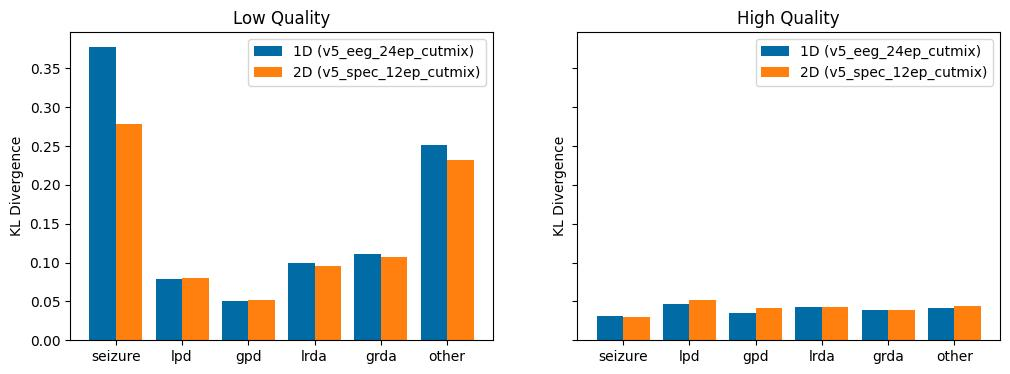

In [14]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
x = np.arange(len(LABELS)).astype(np.float32)
width = 0.4
ax0.bar(x - width / 2, kl_div_low_quality_1d, color="C0", width=width, label="1D (v5_eeg_24ep_cutmix)")
ax0.bar(x + width / 2, kl_div_low_quality_2d, color="C1", width=width, label="2D (v5_spec_12ep_cutmix)")
ax1.bar(x - width / 2, kl_div_high_quality_1d, color="C0", width=width, label="1D (v5_eeg_24ep_cutmix)")
ax1.bar(x + width / 2, kl_div_high_quality_2d, color="C1", width=width, label="2D (v5_spec_12ep_cutmix)")
ax0.set(title="Low Quality", xticks=x, xticklabels=LABELS, ylabel="KL Divergence")
ax1.set(title="High Quality", xticks=x, xticklabels=LABELS, ylabel="KL Divergence")
ax0.legend()
ax1.legend()
plt.show()

## 結果と考察

* 1dと2dの違いは、low quality(vote数3-9)におけるseizureとotherのlossが小さいことが主な原因である。
    * 同じCVでもLBでは1dの方が良い傾向を示すのだとすると、testにも一定割合low-qualityが含まれている可能性がある。

## チームの他のモデル(ariyasu)

- `finetune_hms_chris_fmax30_50sec_16ims_bandpass`

In [19]:
pred_df_ariyasu = pl.read_csv(
    "../../../input/yujiariyasu/hms-ariyasu-oof/finetune_hms_chris_fmax30_50sec_16ims_bandpass.csv"
)
prefix = "pred_"
postfix = ""
pred_ariyasu = (
    pred_df_ariyasu.with_columns(pl.col(f"{prefix}{label}{postfix}").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS, prefix=prefix, postfix=postfix).alias("pl_vote"))
    .with_columns(
        pl.col(f"{prefix}{label}{postfix}").truediv(pl.col("pl_vote")).alias(f"pl_{label}_prob")
        for label in LABELS
    )
).select("eeg_id", *[f"pl_{label}_prob" for label in LABELS])
high_quality_ari = pred_ariyasu.join(high_quality, on="eeg_id", how="inner")
low_quality_ari = pred_ariyasu.join(low_quality, on="eeg_id", how="inner")

gt_df_high_quality_ari = (
    high_quality_ari.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
gt_df_low_quality_ari = (
    low_quality_ari.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_high_quality_ari = (
    high_quality_ari.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_low_quality_ari = (
    low_quality_ari.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
kl_div_high_quality_ari = kl_div(
    gt_df_high_quality_ari,
    pred_df_high_quality_ari,
).mean(axis=0)
kl_div_low_quality_ari = kl_div(
    gt_df_low_quality_ari,
    pred_df_low_quality_ari,
).mean(axis=0)

## チームの他のモデル(tattaka)

- `tiny_vit_21m_384_el30_mixup_50ep`

In [20]:
pred_df_tattaka = pl.read_csv(
    "../data/tattaka_oof/exp092/tiny_vit_21m_384_el30_mixup_50ep/result_df.csv"
)
prefix = "oof_logits_"
postfix = "_vote"
pred_tattaka = (
    pred_df_tattaka.with_columns(
        pl.col(f"{prefix}{label}{postfix}").exp() for label in LABELS
    )
    .with_columns(
        sum_over_labels(LABELS, prefix=prefix, postfix=postfix).alias("pl_vote")
    )
    .with_columns(
        pl.col(f"{prefix}{label}{postfix}")
        .truediv(pl.col("pl_vote"))
        .alias(f"pl_{label}_prob")
        for label in LABELS
    )
).select("eeg_id", *[f"pl_{label}_prob" for label in LABELS])
high_quality_tattaka = pred_tattaka.join(high_quality, on="eeg_id", how="inner")
low_quality_tattaka = pred_tattaka.join(low_quality, on="eeg_id", how="inner")

gt_df_high_quality_tat = (
    high_quality_tattaka.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
gt_df_low_quality_tat = (
    low_quality_tattaka.with_columns(
        [pl.col(f"gt_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_high_quality_tat = (
    high_quality_tattaka.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
pred_df_low_quality_tat = (
    low_quality_tattaka.with_columns(
        [pl.col(f"pl_{label}_prob").alias(f"{label}_vote") for label in LABELS]
    )
    .select(*[f"{label}_vote" for label in LABELS])
    .to_numpy()
)
kl_div_high_quality_tat = kl_div(
    gt_df_high_quality_tat,
    pred_df_high_quality_tat,
).mean(axis=0)
kl_div_low_quality_tat = kl_div(
    gt_df_low_quality_tat,
    pred_df_low_quality_tat,
).mean(axis=0)

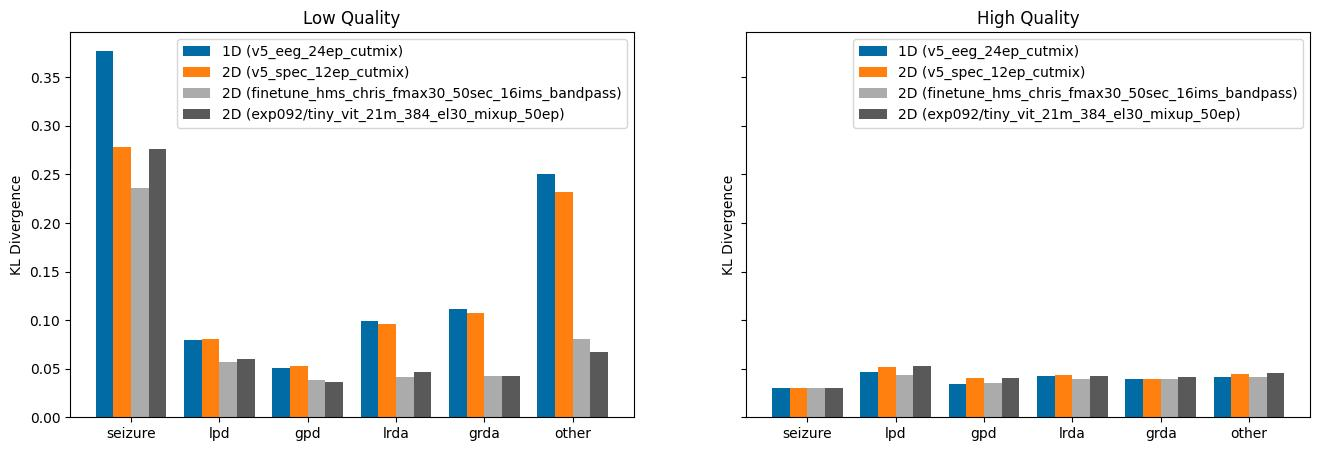

In [25]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
x = np.arange(len(LABELS)).astype(np.float32)
width = 0.2
ax0.bar(
    x - 2 * width + width / 2,
    kl_div_low_quality_1d,
    color="C0",
    width=width,
    label="1D (v5_eeg_24ep_cutmix)",
)
ax0.bar(
    x - width + width / 2,
    kl_div_low_quality_2d,
    color="C1",
    width=width,
    label="2D (v5_spec_12ep_cutmix)",
)
ax0.bar(
    x + width - width / 2,
    kl_div_low_quality_ari,
    color="C2",
    width=width,
    label="2D (finetune_hms_chris_fmax30_50sec_16ims_bandpass)",
)
ax0.bar(
    x + 2 * width - width / 2,
    kl_div_low_quality_tat,
    color="C3",
    width=width,
    label="2D (exp092/tiny_vit_21m_384_el30_mixup_50ep)",
)
ax1.bar(
    x - 2 * width + width / 2,
    kl_div_high_quality_1d,
    color="C0",
    width=width,
    label="1D (v5_eeg_24ep_cutmix)",
)
ax1.bar(
    x - width + width / 2,
    kl_div_high_quality_2d,
    color="C1",
    width=width,
    label="2D (v5_spec_12ep_cutmix)",
)
ax1.bar(
    x + width - width / 2,
    kl_div_high_quality_ari,
    color="C2",
    width=width,
    label="2D (finetune_hms_chris_fmax30_50sec_16ims_bandpass)",
)
ax1.bar(
    x + 2 * width - width / 2,
    kl_div_high_quality_tat,
    color="C3",
    width=width,
    label="2D (exp092/tiny_vit_21m_384_el30_mixup_50ep)",
)
ax0.set(title="Low Quality", xticks=x, xticklabels=LABELS, ylabel="KL Divergence")
ax1.set(title="High Quality", xticks=x, xticklabels=LABELS, ylabel="KL Divergence")
ax0.legend()
ax1.legend()
plt.show()

In [11]:
len(pred_df_low_quality_tat)

414

In [12]:
len(pred_df_low_quality_ari)

414

In [13]:
len(pred_df_low_quality_1d)

6688